In [1]:
# Googleドライブへのマウント（Colab用コード）
from google.colab import drive
drive.mount('/content/drive')
%cd "/content/drive/My Drive/Colab Notebooks/ou_dip/"
from google.colab.patches import cv2_imshow # colab内で画像表示関数がうまく動かないので、パッチが提供されている

Mounted at /content/drive
/content/drive/My Drive/Colab Notebooks/ou_dip


In [2]:
import cv2
import numpy as np  # PythonのOpenCVでは、画像はnumpyのarrayとして管理される
from PIL import Image
import matplotlib.pyplot as plt
%matplotlib inline

def imshow(img):
  if img.ndim == 3:
    img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    display(Image.fromarray(img))
  else:
    display(Image.fromarray(img))

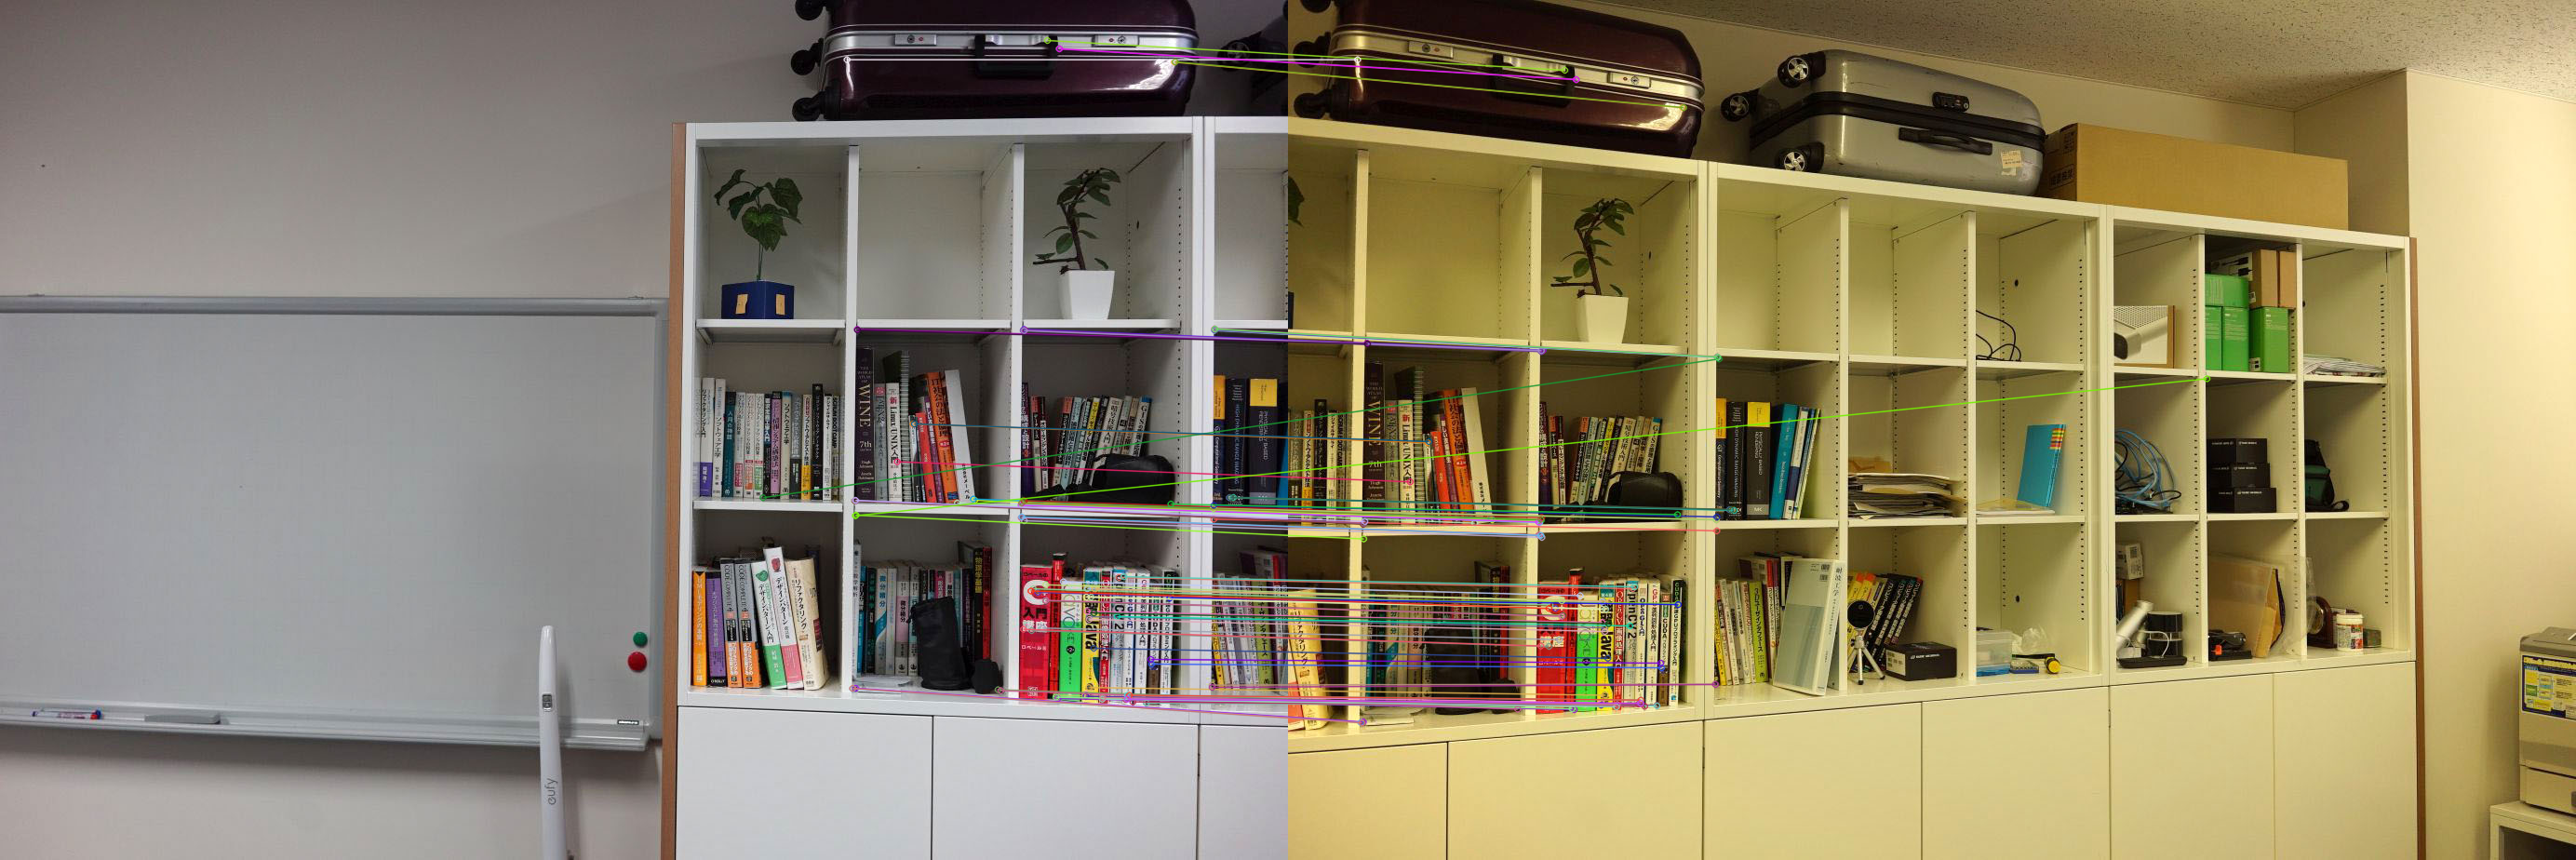

In [3]:
# imgをrefに張り合わせることを考える
ref = cv2.imread("pano_ref.jpg") # ベースとなる画像（BGR）
src = cv2.imread("pano_src.jpg") # 変換する画像（BGR）

# 参考： https://docs.opencv.org/master/db/d27/tutorial_py_table_of_contents_feature2d.html

# ORB を使う場合の例。AKAZEならAKAZE_create、SIFTならSIFT_create
## BRIEFなら keypointがStarDetector_create (FAST特徴点)、descriptorがBriefDescriptorExtractor_create()
## SIFTは、ちょっと古いバージョンのOpenCVには入ってない（特許関係の問題）。特許が切れたので、最近のバージョンは入ってる。
## 精度ならAKAZE、速さならORBがおすすめ。
orb = cv2.ORB_create()

# 各画像に対するkeypointとdescriptorの計算
kp_ref, des_ref = orb.detectAndCompute(ref, None)
kp_src, des_src = orb.detectAndCompute(src, None)

# マッチング。ORBなどはハミング距離（cv2.NORM_HAMMING）。SIFTなどはユークリッド距離（cv2.NORM_L2）。
matcher = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)
matches = matcher.match(des_ref,des_src)

# 距離が小さい順に並べてみる（可視化のため）
matches = sorted(matches, key = lambda x:x.distance)

# 最も小さい距離で対応づいた100組の対応点を可視化してみる
corr_disp = cv2.drawMatches(ref,kp_ref,src,kp_src,matches[:100],None,flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
imshow(corr_disp) # 表示

# 対応点の登録とホモグラフィ行列の推定（w/ RANSAC。閾値は5.0画素にした）
pts_ref = np.float32([ kp_ref[m.queryIdx].pt for m in matches]).reshape(-1,1,2)
pts_src = np.float32([ kp_src[m.trainIdx].pt  for m in matches]).reshape(-1,1,2)
H, mask = cv2.findHomography(pts_src, pts_ref, cv2.RANSAC,5.0)


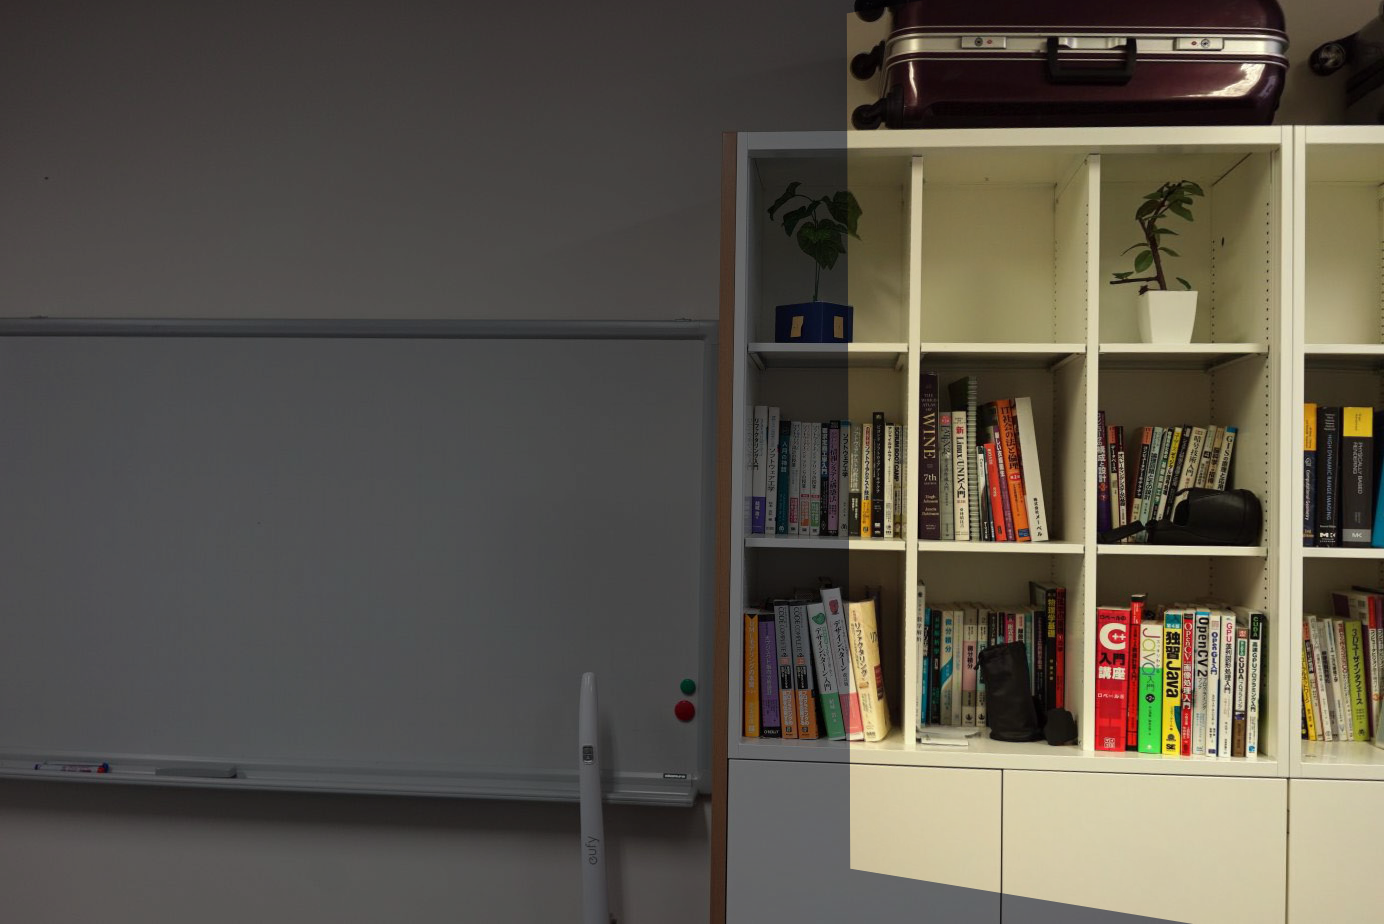

In [22]:
result = cv2.addWeighted(ref, 0.5, warped_img, 0.5, 0)
imshow(result)